# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [ ]:
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.keras import layers, models

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [ ]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [ ]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(max_depth)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [ ]:
X_train, Y_train = generate_dataset(12000)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

In [ ]:
i =  np.random.randint(12000)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

5174
infix :  ( e / a )
posfix notation:  e a /
teacher forcing :  SOS e a /


# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [ ]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

In [ ]:
#def test(no=20,rounds=10):
#  rscores =[]
#  for i in range(rounds):
#    print("round=",i)
#    X_test, Y_test = generate_dataset(no)
#    scores = []
#    for j in range(no):
#      encoder_input=X_test[j]
#      generated = autoregressive_decode(model, encoder_input)[1:] #remove SOS
#      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
#    rscores.append(np.mean(scores))
#  return np.mean(rscores),np.std(rscores)
#
#res, std = test(20,10)
#print("score=",res,"std=",std)"""

Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

----------------------------------------------------------------
#Project development
----------------------------------------------------------------

### Imports and weights loading

In [ ]:
# --- Imports ---
import math
import os
from collections import Counter

import gdown
from pathlib import Path
import json
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#model weights --> to use this weights, change the retrain parameter to False #now fixed correctly
import gdown
!gdown 1wxF3NXw-nHghSZPWGSokrGNFVn1tnhpu

Downloading...
From: https://drive.google.com/uc?id=1wxF3NXw-nHghSZPWGSokrGNFVn1tnhpu
To: /content/infix2postfix.weights.h5
100% 2.82M/2.82M [00:00<00:00, 19.6MB/s]


## 📊 Data Analysis
The data generator uses a binomial (3,0.5) distribution :

$$
P(\mathrm{depth}=k)
\;=\;
\binom{n}{k}\,p^k\,(1-p)^{n-k}
\;=\;
\binom{3}{k}\, \Bigl(\tfrac12\Bigr)^k\Bigl(\tfrac12\Bigr)^{3-k}
\;=\;
\binom{3}{k}\,\Bigl(\tfrac12\Bigr)^3
$$


- **Depth 0** occurs with probability \(1/8\).  
- **Depth 1** and **2** both occur with probability \(3/8\).  
- **Depth 3** occurs with probability \(1/8\).

Because there are only 5 possible depth-0 formulas (one for each identifier  **a** through **e**), in a sample of 10\,000 expressions we expect
$$
[
10\,000 \times \tfrac18 = 1\,250
]
\  i.e.\ on average
[
\frac{1\,250}{5} = 250
]
$$
instances of each identifier at depth 0.  

At greater depths the space of unique formulas grows quickly, so the number of repeatitions per exact structure decreases correspondingly.

**This will lead to partial repetitions in training, validation and test set**

As expicitly said in the exam rules, i will not change the frequency distribution of the generator helping training, but i will increase a litlle the training dimension to 12k to enlarge the dimensions (letting the model train on more depth 3 expressions).

### Custom evaluation at test time
At test time i will test the model:
- with the prescribed stanard generator
- with another custom generator which outputs formulas fixed at depth 3 **to evaluate model generalization on harder formulas**.

In [ ]:
#formula generator at depth 3 for testing model performances
def generate_exact_depth_expression(depth):
    """
    Generate infix expression with exactly the given depth
    """
    if depth == 0:
        return random.choice(IDENTIFIERS)
    else:
        left=generate_exact_depth_expression(depth-1)
        right= generate_exact_depth_expression(depth-1)
        op =random.choice(OPERATORS)
        return f'({left} {op} {right})'

def generate_dataset_depth3(n):
    """
    Generate dataset of n infix expressions of depth 3
    """
    X,Y= [],[]
    for _ in range(n):
        expr =generate_exact_depth_expression(3)
        infix =tokenize(expr)
        postfix =infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X),np.array(Y)

## 🧠 Model Selection

This is a **Sequence-to-Sequence(Seq2Seq)** task aiming at translating fully mathematical expressions from infix to postfix notation (RPN).

### Model Candidates i see:
1. **LSTM based Encoder-Decoder with Attention**
2. **Transformer based Encoder-Decoder or Decoder only**

### Comparative Analysis:

| Aspect                     | LSTM + Attention           | Transformer                 |
|---------------------------|----------------------------|-----------------------------|
| Parallelization           | ❌Low (sequential)         | ✅ High                     |
| Memory Efficiency         | ✅Better                   | ❌ Higher cost       |
| Parameter Efficiency      | ✅ Fewer parameters         | ❌A little bit more but well under 2 millions for this task     |
| Generalization to Formula Depth  | ❌ May struggle             | ✅ Handles nested structures well |
| Training Speed (short seq) | ❌ Slower                   | ✅ Faster per epoch         |

### Final Choice:

Due to the following reasons:
- Transformers are better suited to capture long-range dependencies in symbolic data.
- It is feasible to build a Transformer under the 2M parameter limit.
- Future scalability is desirable in case of increased expression depth or broader syntax.

**I chose a Transformer-based encoder-decoder architecture** for this project.

**At the end of the notebook i will report also the results obtained with LSTM architecture**


## Transformer encoder-decoder
Here are described the parameters setting:
- d_model=32
- num_encoders=3
- encoder_attention_heads=4
- encoder_ff_dim=128
- num_decoders=3
- decoder_attention_heads=4
- decoder_ff_dim=128
- BATCH_SIZE = 64
- EPOCHS = 20

For the sake of this task, model's parameters could also be reduced even more, but the model would become very poorly generalizable.

What i'm trying to do is making a model which learn rules and patterns for infix-RPN generation, not memorize combinations.

### Model parameters: 203.247


In [ ]:
class Token_Position_Embedding(keras.layers.Layer):
    """
    Combines learned token embeddings with fixed sinusoidal positional encodings (like in the original Transformers paper "Attention is all you need").
    Attributes:
        token_embedding: embedding layer mapping token IDs to vectors.
        pos_encoding: Precomputed positional encoding matrix.
        max_length: Maximum sequence length for which pos encodings were computed.
        embed_dim: Dimensionality of the embedding vectors.
    """
    def __init__(self, max_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_encoding = self.positionalEncoding(length=max_length,depth=embed_dim)
        self.max_length = max_length
        self.embed_dim = embed_dim


    def positionalEncoding(self,length,depth):
        depth = depth / 2
        positions = np.arange(length)[:, np.newaxis]
        depths = np.arange(depth)[np.newaxis, :] / depth
        angle_rates = 1 / (10000**depths)
        angle_rads = positions * angle_rates
        return tf.cast(np.concatenate( [np.sin(angle_rads), np.cos(angle_rads)], axis=-1), dtype=tf.float32)


    def call(self, x, training):
        x = self.token_embedding(x, training=training)
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :tf.shape(x)[1], :]
        return x

In [ ]:
class Transformer_Encoder(keras.layers.Layer):
    """
    The layer implements one encoder block from the original paper "Attention is all you need".
    Initially it does a multi-head self attention followed by a position wise feed forward network,
    each wrapped with residual connections and a layer normalization.
    """
    def __init__(self, att_heads=6, embed_dim=128, ff_dim=1024, activation="swish", dropout=0.1, **kwargs):
        super().__init__(**kwargs)

        self.attention_heads = keras.layers.MultiHeadAttention(num_heads=att_heads, key_dim=embed_dim, dropout=dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-5)

        self.ff_block = keras.Sequential([
            keras.layers.Dense(ff_dim, activation=activation),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(embed_dim),
        ])
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-5)


    def call(self, inputs, training):
        attention_out = self.attention_heads(
            query = inputs,
            value = inputs,
            key = inputs,
            training = training
        )
        attention_out = self.attention_norm(attention_out + inputs, training=training)
        ff_out = self.ff_block(attention_out, training=training)
        return self.ff_norm(ff_out + attention_out, training=training)

In [ ]:
class Transformer_Decoder(keras.layers.Layer):
    """
    The layer implements a decoder block from the original paper "Attention is all you need".
    Initially it applies masked multi-head self-attention to the target sequence (preventing positions for attending future tokens)
    then attends to the enc.output via multi head cross attention and passes the output to a position wise feed forward network.
    Each wrapped with residual connections and a layer normalization.
    """
    def __init__(self, att_heads=6, embed_dim=128,ff_dim=1024, activation="swish",dropout=0.1,**kwargs):
        super().__init__(**kwargs)

        self.attention_heads1 = keras.layers.MultiHeadAttention(num_heads=att_heads,key_dim=embed_dim,dropout=dropout)
        self.attention_heads2 = keras.layers.MultiHeadAttention(num_heads=att_heads,key_dim=embed_dim,dropout=dropout)

        self.attention_norm1 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attention_norm2 = keras.layers.LayerNormalization(epsilon=1e-5)

        self.ff_block = keras.Sequential([
            keras.layers.Dense(ff_dim, activation=activation),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(embed_dim),
        ])
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-5)


    def call(self,inputs, encoder_out,training):
        attention1_out = self.attention_heads1(
            query = inputs,
            value = inputs,
            key = inputs,
            use_causal_mask = True,
            training = training
        )
        attention1_out = self.attention_norm1(attention1_out + inputs, training=training)

        attention2_out = self.attention_heads2(
            query = attention1_out,
            value = encoder_out,
            key = encoder_out,
            training = training
        )
        attention2_out = self.attention_norm2(attention2_out + attention1_out, training=training)

        ff_out = self.ff_block(attention2_out, training=training)
        return self.ff_norm(ff_out + attention2_out, training=training)

In [ ]:
class InfixToPostfixTransformer(keras.Model):
    """
    Here i implement a seq-2-seq transformer
    It consists of:
    - token and position embedding layer to encode intput and output sequences
    - a stack of transformer encoder blocks to process the infix input
    - a stack of transfofmer decoder blocks to generate output in postfix form, attending the encoder features
    - a final softmax layer that predicts the next token in the output sequence
    """
    def __init__(self,
        input_size =MAX_LEN,
        vocab_size =VOCAB_SIZE,
        d_model =256,
        num_encoders =3,
        encoder_attention_heads =6,
        encoder_ff_dim =512,
        num_decoders =3,
        decoder_attention_heads =6,
        decoder_ff_dim =512,
        activation ="swish",
        **kwargs
    ):
        super().__init__(**kwargs)

        self.embedding= Token_Position_Embedding(input_size, vocab_size,d_model,name="embedding")
        self.encoders_block= [
            Transformer_Encoder(embed_dim=d_model,att_heads=encoder_attention_heads,ff_dim=encoder_ff_dim,activation=activation,name=f"encoder{i}")
            for i in range(num_encoders)
         ]
        self.decoders_block= [
            Transformer_Decoder(embed_dim=d_model,att_heads=decoder_attention_heads,ff_dim=decoder_ff_dim,activation=activation,name=f"decoder{i}" )
            for i in range(num_decoders)
         ]
        self.final_layer = keras.layers.Dense(vocab_size,activation="softmax",name="softmax")


    def call(self,inputs,training=False):
        encoder_in, decoded_in = inputs

        encoder_out =self.embedding(encoder_in, training=training)
        for i in range(len(self.encoders_block)):
            encoder_out=self.encoders_block[i](encoder_out, training=training)

        decoder_out =self.embedding(decoded_in, training=training)
        for i in range(len(self.decoders_block)):
            decoder_out=self.decoders_block[i](decoder_out, encoder_out, training=training)

        return self.final_layer(decoder_out, training=training)

### Model initialization

In [ ]:
d_model = 32

model = InfixToPostfixTransformer(
    d_model = d_model ,
    num_encoders = 3,
    encoder_attention_heads = 4,
    encoder_ff_dim = 128,
    num_decoders = 3,
    decoder_attention_heads = 4,
    decoder_ff_dim = 128,
)

# here i build the input layers for the encoder and the decoder
inputs = [
    keras.layers.Input(shape=(MAX_LEN,), name="encoder-in"),
    keras.layers.Input(shape=(MAX_LEN,), name="decoder-in")
]

keras.Model(inputs=inputs, outputs=model.call(inputs)).summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder-in          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder-in          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 32)    │        480 │ encoder-in[0][0], │
│ (Token_Position_Em… │                   │            │ decoder-in[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder0            │ (None, 30, 32)    │     25,280 │ embedding[0][0]   │
│ (Transformer_Encod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1            │ (None, 30, 32)    │     25,280 │ encoder0[0][0]    │
│ (Transformer_Encod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2            │ (None, 30, 32)    │     25,280 │ encoder1[0][0]    │
│ (Transformer_Encod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder0            │ (None, 30, 32)    │     42,144 │ embedding[1][0],  │
│ (Transformer_Decod… │                   │            │ encoder2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder1            │ (None, 30, 32)    │     42,144 │ decoder0[0][0],   │
│ (Transformer_Decod… │                   │            │ encoder2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder2            │ (None, 30, 32)    │     42,144 │ decoder1[0][0],   │
│ (Transformer_Decod… │                   │            │ encoder2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Dense)     │ (None, 30, 15)    │        495 │ decoder2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 203,247 (793.93 KB)

 Trainable params: 203,247 (793.93 KB)

 Non-trainable params: 0 (0.00 B)

### Custom loss and accuracy definition

In [ ]:
# ---Loss and accuracy custom functions---
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False,reduction='none')

#loss and accuracy built to ignore empty pad sequences
def masked_loss(y_true, y_pred):
    loss_1 = loss(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, PAD_ID), loss_1.dtype)
    loss_1 *= mask
    return tf.reduce_sum(loss_1) / tf.reduce_sum(mask)

def masked_accuracy(y_true,y_pred):
    y_preds_ids=  tf.argmax(y_pred,axis=-1,output_type=y_true.dtype  )
    matches=tf.cast(tf.equal(y_true,y_preds_ids),tf.float32)
    mask=tf.cast(tf.not_equal(y_true,PAD_ID),tf.float32 )
    matches*=mask
    return tf.reduce_sum(matches)/tf.reduce_sum(mask)

### Autoregressive decode
This function output the postfix formula asking each time the model to predict the next token based on the already predicted ones.

In [ ]:
# used only during generation in evaluation and in callback to see model prediction
def autoregressive_decode(model, encoder_input, max_len=MAX_LEN):
    """
    I apply a Greedy decoding
    """
    enc_in= encoder_input.reshape(1, -1)
    dec_in= np.full((1, max_len), PAD_ID, dtype=np.int32)
    dec_in[0,0]=SOS_ID

    for t in range(1, max_len):
        preds      =   model.predict([enc_in, dec_in], verbose=0)
        next_id    =   int(np.argmax(preds[0, t-1]))
        dec_in[0, t] = next_id
        if next_id ==  EOS_ID:
            break
    return dec_in[0]

### Custom callback
To see formula prediction during training.

In [ ]:
class Custom_Callback(tf.keras.callbacks.Callback):
    """
    This custom callback periodically evaluates the model by generating a small test
    """
    def __init__(self, every_n_epochs=5,n_examples=4,max_depth=MAX_DEPTH):
        super().__init__()
        self.every_n_epochs= every_n_epochs
        self.n_examples =n_examples
        self.max_depth =max_depth

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % self.every_n_epochs==0)or(epoch==0):
            X_test,Y_test= generate_dataset(self.n_examples, self.max_depth)
            print("\n"+"="*60 )
            print(f"Predictions at epoch {epoch + 1}")
            print("="*60 )
            for i in range(self.n_examples):
                x = X_test[i]
                y = Y_test[i]
                y_pred_ids = autoregressive_decode(self.model, x)[1:]  # remove SOS

                infix   =decode_sequence(x, id_to_token)
                target  =decode_sequence(y, id_to_token)
                pred    =decode_sequence(y_pred_ids, id_to_token)
                acc     =prefix_accuracy_single(y, y_pred_ids, id_to_token)

                print(f"Infix : {infix}")
                print(f"Target: {target}")
                print(f"Predicted: {pred}   | prefix acc = {acc:.2f}")
                print("-" * 60)
            print("=" * 60 +"\n")


### Loading and training
Here we compile and train the model (or reuse past weights), the dimensions are kept low but sufficient to get a good score and loss.

In [ ]:
def load_or_train_model(
    file_path:str="infix2postfix.weights.h5",
    retrain:bool=True,
) -> tuple[keras.Model,keras.callbacks.History|None]:

    #if the file exists, load the old model weights
    if os.path.exists(file_path) and not retrain:
        # Re-create the same model architecture
        model = InfixToPostfixTransformer(
            d_model=32,
            num_encoders=3,
            encoder_attention_heads=4,
            encoder_ff_dim=128,
            num_decoders=3,
            decoder_attention_heads=4,
            decoder_ff_dim=128,
        )
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss=masked_loss,
            metrics=[masked_accuracy]
        )
        # I initialize a dummy model to load weights
        dummy_encod= tf.zeros((1,MAX_LEN),dtype=tf.int32)
        dummy_decod= tf.zeros((1,MAX_LEN),dtype=tf.int32)
        _ =model([dummy_encod,dummy_decod])

        # Here i load the actual weights
        model.load_weights(file_path)
        print(f"Loaded weights from {file_path}")
        model.summary()
        return model,None

    # Build and train a new model --> retrain is true
    print("\n Building and training the new model")
    model = InfixToPostfixTransformer(
        d_model=32,
        num_encoders=3,
        encoder_attention_heads=4,
        encoder_ff_dim=128,
        num_decoders=3,
        decoder_attention_heads=4,
        decoder_ff_dim=128,
    )
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=masked_loss,
        metrics=[masked_accuracy]
    )

    #hyperparameters
    BATCH_SIZE=64
    EPOCHS=20

    #data preparation
    train_ds=tf.data.Dataset.from_tensor_slices(((X_train, decoder_input_train), Y_train)).shuffle(10_000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_ds=tf.data.Dataset.from_tensor_slices(((X_val, decoder_input_val), Y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    #training the new model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss",patience=5), #after 5 epochs of no improvements, the training stops
            Custom_Callback(every_n_epochs=5,n_examples=4)
        ]
    )
    #from google.colab import drive
    #drive.mount('/content/drive',force_remount=True)
    #drive_weights_path = "/content/drive/MyDrive/infix2postfix.weights.h5"
    #
    #model.save_weights(drive_weights_path)
    #print(f"Weights also saved to Google Drive: {drive_weights_path}")

    # Saving the weights locally
    model.save_weights(file_path)
    print(f"\nWeights saved to {file_path}")

    return model, history

In [ ]:
def plot_training_history(history: keras.callbacks.History | None) -> None:
    """
    Function to plot the custom loss and accuracy history during the training
    """
    if history is None:
        print("Train the model to see actual history")
        return

    # Plot the Custom Loss
    plt.figure()
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'],  label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the Custom Accuracy
    plt.figure()
    plt.plot(history.history['masked_accuracy'], label='Training Masked Accuracy')
    plt.plot(history.history['val_masked_accuracy'], label='Validation Masked Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Masked Accuracy')
    plt.title('Training and Validation Masked Accuracy')
    plt.legend()
    plt.show()


### Model Training

In [ ]:
model,history=load_or_train_model(file_path="infix2postfix.weights.h5",retrain=True)


 Building and training the new model
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 2.0853 - masked_accuracy: 0.2256
Predictions at epoch 1
Infix : ( ( c / e ) - ( c + ( e * b ) ) )
Target: c e / c e b * + -
Predicted: e e / e c c / /   | prefix acc = 0.22
------------------------------------------------------------
Infix : ( d * d )
Target: d d *
Predicted: d d /   | prefix acc = 0.67
------------------------------------------------------------
Infix : ( ( ( b / a ) - a ) * ( d - a ) )
Target: b a / a - d a - *
Predicted: a a * a a a * *   | prefix acc = 0.22
------------------------------------------------------------
Infix : ( ( ( a * c ) - d ) - c )
Target: a c * d - c -
Predicted: a a a * a *   | prefix acc = 0.14
------------------------------------------------------------

188/188 ━━━━━━━━━━━━━━━━━━━━ 69s 147ms/step - loss: 2.0836 - masked_accuracy: 0.2259 - val_loss: 1.5207 - val_masked_accuracy: 0.3993
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss:

### Plot of the training history

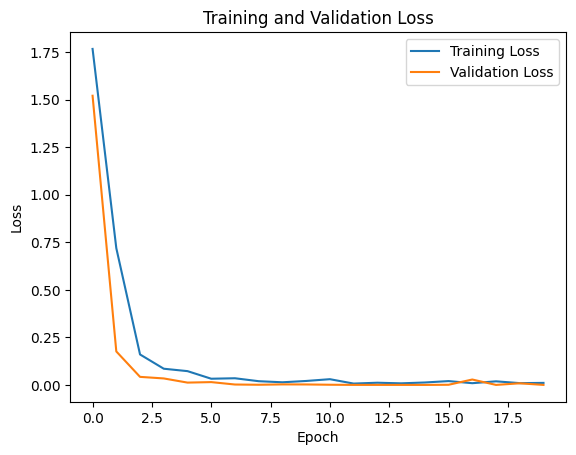

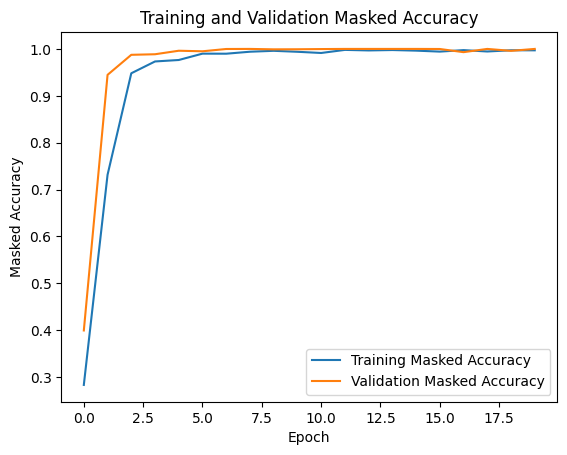

In [ ]:
plot_training_history(history)

### Model testing
Using the prescribed generator of all sizes from 0 to 3

In [ ]:
#---Testing the model---
def test(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input=X_test[j]
      generated = autoregressive_decode(model, encoder_input)[1:] #remove SOS
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

res, std = test(20,10)
print("score=",res,"std=",std)

round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 1.0 std= 0.0


### Model testing 2
To see if the model acquired general rules, test at fixed depth 3.

In [ ]:
#---Testing the model at fixed depth 3---
def test_custom(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset_depth3(no) #formula generator at depth 3 fixed
    scores = []
    for j in range(no):
      encoder_input=X_test[j]
      generated = autoregressive_decode(model, encoder_input)[1:] #remove SOS
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

res, std = test_custom(20,10)
print("score=",res,"std=",std)

round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 1.0 std= 0.0


### Example of model RPN prediction

In [ ]:
#---some example of predictions made by the model---
X_test, Y_test = generate_dataset(4)
for i in range(4):
    x =X_test[i]
    y =Y_test[i]
    y_pred_ids = autoregressive_decode(model, x)[1:]
    infix  = decode_sequence(x,id_to_token)
    target = decode_sequence(y,id_to_token)
    pred   = decode_sequence(y_pred_ids,id_to_token)
    acc    = prefix_accuracy_single(y,y_pred_ids,id_to_token)
    print(f"Infix :   {infix}")
    print(f"Target:   {target}")
    print(f"Predicted:{pred}|prefix acc= {acc:.2f}")
    print("-" * 50)


Infix :   ( ( d + c ) * d )
Target:   d c + d *
Predicted:d c + d *|prefix acc= 1.00
--------------------------------------------------
Infix :   ( ( d + c ) + ( ( d - e ) + d ) )
Target:   d c + d e - d + +
Predicted:d c + d e - d + +|prefix acc= 1.00
--------------------------------------------------
Infix :   ( ( c + b ) / ( ( e - a ) - ( c + d ) ) )
Target:   c b + e a - c d + - /
Predicted:c b + e a - c d + - /|prefix acc= 1.00
--------------------------------------------------
Infix :   ( ( e - e ) - ( d * ( c / d ) ) )
Target:   e e - d c d / * -
Predicted:e e - d c d / * -|prefix acc= 1.00
--------------------------------------------------


# Score Analysis

##**SCORE: 1.0** - **Standard Deviation: 0.0**


The model is able to give perfect score on general dataset of all dimension and also on dataset of depth 3 (0.99-1), explicitly evidencing how the model is well able to learn all the patterns up to depth 3.

This perfect score is the result of several favorable factors:

- **Limited expression space**  
  The data generator produces formulas with bounded depth and limited variability. Many expressions or sub-expressions are seen multiple times during training, and testing.

- **Depth limited to 3**  
  By capping the syntactic depth, the model faces a manageable number of structural patterns. This simplifies the learning task and helps the model capture all meaningful variations.

- **Parenthesized infix expressions**  
  The use of parentheses in every operation removes ambiguity related to operator precedence or associativity. This clarity allows the model to focus purely on syntax conversion, not interpretation.

---

> ⚠️ If the expression depth or vocabulary were increased, or if parentheses were removed, the model would surely require more parameters.

## 🔁 Comparison with LSTM-based Architecture

Here i compare the results obtained with the Transformer model to those achieved using a variation of an LSTM encoder-decoder architecture, enhanced with **Bahdanau attention**.


A small LSTM decoder-encoder architecture can obtain similar results (score  around 0.99-1) with around the same number of parameters. For the sake of generalization (in case of increasing depth in future experiments) and since we saw transformer architectures during the course's labs, i decided to choose it to show in the project ipynb file.

Moreover, Transformers offer better parallelization capabilities during training and inference, which can become a significant advantage as the model scales. The self-attention mechanism is also inherently more flexible for handling variable-length sequences, which may be beneficial if the input structure evolves beyond the current constraints.

